In [1]:
import pandas as pd
import numpy as np

from google.oauth2 import service_account
from google.cloud import bigquery

In [2]:
SERVICE_ACCOUNT_FILE = "./key/api_key_carsharing.json"  # 키 json 파일
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)
project_id = "carsharing-454809"
dataset_name = "carsharing"
client = bigquery.Client(credentials=credentials, project=project_id)

def import_bigquery_data(query):
    query_job = client.query(query)
    return query_job.to_dataframe()

In [3]:
query1 = (f"""select * from {project_id}.{dataset_name}.licenses""")
query2 = (f"""select * from {project_id}.{dataset_name}.greencars""")
query3 = (f"""select * from {project_id}.{dataset_name}.transports""")
query4 = (f"""select * from {project_id}.{dataset_name}.sites""")

In [4]:
df2_licenses = import_bigquery_data(query1)
filtered_df1_greencar = import_bigquery_data(query2)
df3_transport = import_bigquery_data(query3)
df4_poi = import_bigquery_data(query4)
top_100 = df4_poi.head(100)

In [5]:
region_total_mapping = {
    '서울특별시': ['서울']+sorted([
                        "종로구", "중구", "용산구", "성동구", "광진구", "동대문구", "중랑구", 
                        "성북구", "강북구", "도봉구", "노원구", "은평구", "서대문구", "마포구", 
                        "양천구", "강서구", "구로구", "금천구", "영등포구", "동작구", "관악구", 
                        "서초구", "강남구", "송파구", "강동구"
                        ], reverse=True),
    '세종특별자치시':["세종"],
    '부산광역시': ["부산"],
    '대구광역시': ['대구'],
    '인천광역시': ['인천'],
    '광주광역시': ["광주광역시"],
    '대전광역시': ["대전"],
    '울산광역시': ["울산"],
    '광주광역시': ["광주"],
    '경기도': ['경기', '수원시', '고양시', '화성시', '성남시', '용인시', '부천시', '안양시', '시흥시', '기타 경기도 지역'],
    '강원도': ['강원', '춘천시', '강릉시', '원주시', '기타 강원도 지역'],
    '경상남도': ['경남', '창원시', '김해시', '기타 경상남도 지역'],
    '경상북도': ['경북', '포항시', '경주시', '기타 경상북도 지역'],
    '전라남도': ['전남', '여수시', '순천시', '목포시', '기타 전라남도 지역'],
    '전라북도': ['전북', '전주시', '군산시', '익산시', '기타 전라북도 지역'],
    '충청남도': ['충남', '천안시', '아산시', '기타 충청남도 지역'],
    '충청북도': ['충북', '청주시', '충주시', '기타 충청북도 지역'],
    '제주특별자치도': ['제주', '서귀포']}

In [6]:
# 주소 encoding 컬럼 추출
address_columns = [
    col for col in filtered_df1_greencar.columns
    if col not in ['zoneName', 'address', 'latitude', 'longitude', 'cluster', 'core', 'radius']
]

# 각 주소 컬럼별 차고지 갯수 계산
garage_counts = {
    col: filtered_df1_greencar[col].sum() for col in address_columns
}

# 결과를 DataFrame으로 변환
df_garage = pd.DataFrame(list(garage_counts.items()), columns=['Region', 'Garage_Count'])
df_garage = df_garage.sort_values(by='Garage_Count', ascending=False).reset_index(drop=True)

address_list = list(region_total_mapping.keys())
df_garage = df_garage[df_garage['Region'].isin(address_list)]
df_garage


,Region,Garage_Count
0,서울특별시,491
1,경기도,446
3,부산광역시,153
4,인천광역시,137
5,경상북도,93
6,대구광역시,91
7,경상남도,90
8,광주광역시,68
11,충청남도,46
12,전라남도,45


In [7]:
import altair as alt

# 막대 그래프 생성
chart = alt.Chart(df_garage).mark_bar().encode(
    x=alt.X('Garage_Count:Q', title='Garage Count'),
    y=alt.Y('Region:O', sort='-x', title='Region'),  # 내림차순 정렬
    tooltip=['Region', 'Garage_Count']  # Tooltip에 추가 정보 표시
).properties(
    title='Garage Count by Address',
    width=800,
    height=800
)

chart

alt.Chart(...)

In [8]:
df_garage_licenses = pd.merge(df_garage, df2_licenses, on='Region', how='outer')
df_garage_licenses['license'] = df_garage_licenses['license'].astype(int)
df_garage_licenses

,Region,Garage_Count,license
0,서울특별시,491,6024859
1,경기도,446,8708245
2,부산광역시,153,1883885
3,인천광역시,137,1823597
4,경상북도,93,1528795
5,대구광역시,91,1461003
6,경상남도,90,1940391
7,광주광역시,68,866628
8,충청남도,46,1266080
9,전라남도,45,987358


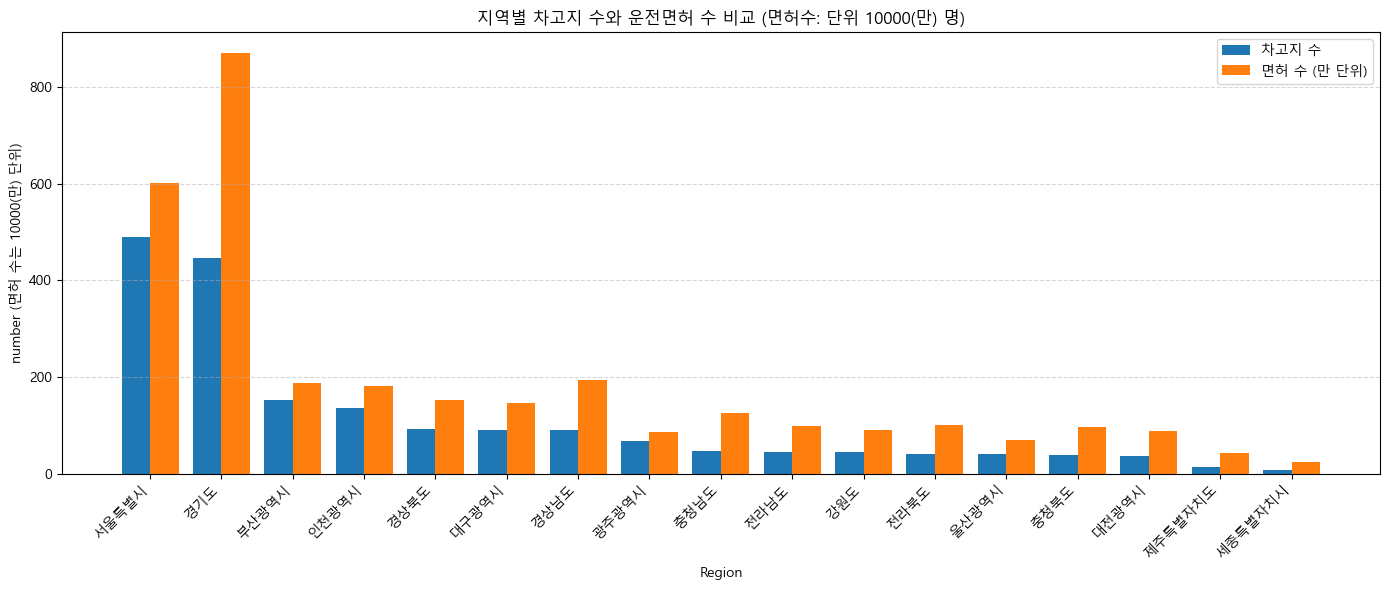

In [9]:
import matplotlib.pyplot as plt

# 한글 폰트 설정 (윈도우 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터프레임 이름: df_garage_licenses
x = np.arange(len(df_garage_licenses))
bar_width = 0.4

# 면허 수 천 단위로 나누기
license_scaled = df_garage_licenses['license'] / 10000  # 단위: 만 명

plt.figure(figsize=(14, 6))

# 차고지 수
plt.bar(x - bar_width/2, df_garage_licenses['Garage_Count'], width=bar_width, label='차고지 수')

# 면허 수 (단위 조정)
plt.bar(x + bar_width/2, license_scaled, width=bar_width, label='면허 수 (만 단위)')

# x축 설정
plt.xticks(x, df_garage_licenses['Region'], rotation=45, ha='right')
plt.xlabel('Region')
plt.ylabel('number (면허 수는 10000(만) 단위)')
plt.title('지역별 차고지 수와 운전면허 수 비교 (면허수: 단위 10000(만) 명)')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


In [10]:
df_garage_licenses["relative_Garage_Count"] = df_garage_licenses["Garage_Count"]/df_garage_licenses["Garage_Count"].max()
df_garage_licenses["relative_license"] = df_garage_licenses["license"]/df_garage_licenses["license"].max()
df_garage_licenses["relative_score"] = (df_garage_licenses["relative_Garage_Count"])/df_garage_licenses["relative_license"]


In [11]:
# 점 그래프: Garage_Count vs license
scatter_chart = alt.Chart(df_garage_licenses).mark_circle(size=100).encode(
    x=alt.X('Garage_Count:Q', title='Garage Count'),
    y=alt.Y('license:Q', title='License Count'),
    color=alt.Color('Region:N', title='Region'),
    tooltip=['Region', 'Garage_Count', 'license']
).properties(
    title='Garage Count vs License Count',
    width=800,
    height=400
)

scatter_chart


alt.Chart(...)

In [12]:
def generate_circle(lat, lon, radius, n_points=50):
    """
    중심 좌표(lat, lon)와 반경(radius)를 이용해 원형 다각형의 좌표를 생성.
    :param lat: 위도
    :param lon: 경도
    :param radius: 반경 (미터 단위)
    :param n_points: 다각형을 구성할 점의 수
    :return: 원형 다각형의 좌표 리스트
    """
    angles = np.linspace(0, 2 * np.pi, n_points)
    earth_radius = 6371000  # 지구 반경 (미터)
    
    # 위도와 경도의 단위를 라디안으로 변환
    lat_radians = np.radians(lat)
    lon_radians = np.radians(lon)
    
    circle_coords = []
    for angle in angles:
        d_lat = radius / earth_radius * np.cos(angle)
        d_lon = radius / (earth_radius * np.cos(lat_radians)) * np.sin(angle)
        
        new_lat = lat_radians + d_lat
        new_lon = lon_radians + d_lon
        
        circle_coords.append([np.degrees(new_lon), np.degrees(new_lat)])
    
    return circle_coords

In [13]:
import hdbscan

# 1. 위도와 경도 데이터 선택
coords = filtered_df1_greencar[['latitude', 'longitude']].dropna()

# HDBSCAN 모델 학습 (coords는 위도와 경도 데이터)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
hdbscan_model.fit(coords)

# 클러스터 레이블 추가
filtered_df1_greencar['cluster'] = hdbscan_model.labels_

# 코어 멤버 여부 추가
filtered_df1_greencar['core'] = hdbscan_model.probabilities_ == 1

# 코어 멤버만 필터링
core_members = filtered_df1_greencar[filtered_df1_greencar['core']]

# 결과 확인
print(f"Number of core members: {len(core_members)}")
print(core_members.head())
# 결과 확인
num_clusters = len(set(hdbscan_model.labels_)) - (1 if -1 in hdbscan_model.labels_ else 0)
print(f"Number of clusters found: {num_clusters}")
print(filtered_df1_greencar['cluster'].value_counts())

Number of core members: 843
       zoneName                  address  latitude  longitude  서울특별시  세종특별자치시  \
1   울산시외버스터미널 뒤         울산 남구 달동 1301-11    35.536    129.338      0        0   
2      서부여성회관 옆            인천시 서구 서달로 16    37.500    126.679      0        0   
8      롯데마트 상록점  경기도 안산시 상록구 반석로 20(본오동)    37.297    126.861      0        0   
9      당리역 2번출구            부산 사하구 하단동 80    35.103    128.970      0        0   
10     소사역 1번출구       경기 부천시 소사구 경인로 349    37.483    126.795      0        0   

    부산광역시  대구광역시  인천광역시  광주광역시  ...  기타 경기도 지역  기타 강원도 지역  기타 경상남도 지역  \
1       0      0      0      0  ...          0          0           0   
2       0      0      1      0  ...          0          0           0   
8       0      0      0      0  ...          1          0           0   
9       1      0      0      0  ...          0          0           0   
10      0      0      0      0  ...          0          0           0   

    기타 경상북도 지역  기타 전라남도 지역  기타 전라북도 지역  기타 충청남

In [14]:
# 1. 위도와 경도 데이터 선택
coords = df3_transport[['latitude', 'longitude']].dropna()

# HDBSCAN 모델 학습 (coords는 위도와 경도 데이터)
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
hdbscan_model.fit(coords)

# 클러스터 레이블 추가
df3_transport['cluster'] = hdbscan_model.labels_

# 코어 멤버 여부 추가
df3_transport['core'] = hdbscan_model.probabilities_ == 1
# 코어 멤버만 필터링
transport_core_members = df3_transport[df3_transport['core']]

# 결과 확인
print(f"Number of core members: {len(transport_core_members)}")
print(transport_core_members.head())
# 결과 확인
num_clusters = len(set(hdbscan_model.labels_)) - (1 if -1 in hdbscan_model.labels_ else 0)
print(f"Number of clusters found: {num_clusters}")
print(filtered_df1_greencar['cluster'].value_counts())

Number of core members: 52677
        POI_NM CTPRVN_NM SIGNGU_NM LEGALDONG_NM LI_NM  longitude  latitude  \
1    청주시외버스터미널      충청북도   청주시 흥덕구          가경동     0    127.432    36.625   
2      터미널지하차도      충청북도   청주시 흥덕구          가경동     0    127.430    36.626   
3   시외버스터미널사거리      충청북도   청주시 흥덕구          가경동     0    127.431    36.625   
4      시외버스터미널      충청북도   청주시 흥덕구          가경동     0    127.432    36.625   
15    죽림동버스정류장      충청북도   청주시 흥덕구          가경동     0    127.440    36.612   

    cluster  core  
1      4591  True  
2      4591  True  
3      4591  True  
4      4591  True  
15     4584  True  
Number of clusters found: 6472
cluster
-1     408
 17    158
 9      72
 26     50
 70     46
      ... 
 55      6
 40      6
 28      6
 41      5
 56      5
Name: count, Length: 81, dtype: int64


In [15]:
import pydeck as pdk

# GreenCar 데이터 Layer
greencar_layer = pdk.Layer(
    "ScatterplotLayer",
    data=filtered_df1_greencar,
    get_position=["longitude", "latitude"],
    get_fill_color=[0, 255, 0, 160],  # Green color with transparency
    get_radius=700,
)
print(len(filtered_df1_greencar))
# sites 데이터 Layer
sites_layer = pdk.Layer(
    "ScatterplotLayer",
    data=df4_poi,
    get_position=["longitude", "latitude"],
    get_fill_color=[255, 0, 255, 255],  # Pink color with transparency
    get_radius=1000,
)
print(len(df4_poi))
# Transport 데이터 Layer
transport_layer = pdk.Layer(
    "ScatterplotLayer",
    data=df3_transport,
    get_position=["longitude", "latitude"],
    get_fill_color=[0, 0, 255, 100],  # Blue color with transparency
    get_radius=500,
)
print(len(df3_transport))
# View 설정
view_state = pdk.ViewState(
    latitude=filtered_df1_greencar["latitude"].mean(),
    longitude=filtered_df1_greencar["longitude"].mean(),
    zoom=7,
)

# Pydeck Deck 생성
r = pdk.Deck(
    layers=[transport_layer, sites_layer, greencar_layer],
    initial_view_state=view_state,
)


1862
378
142937


In [16]:
import altair as alt

# Altair 데이터 제한 해제
alt.data_transformers.disable_max_rows()

top_10 = df4_poi.head(10)

# Altair로 시각화
chart = (
    alt.Chart(top_10)
    .mark_bar(size=40)
    .encode(
        y=alt.Y(
            "POI_NM:N",
            title=None,
            sort=alt.EncodingSortField(
                field="SCCNT_VALUE",  # 정렬 기준 열
                order="descending",  # 내림차순 정렬
            ),
        ),
        x=alt.X("SCCNT_VALUE:Q", title="검색량", sort="ascending"),
        color=alt.Color(
            "SCCNT_VALUE:Q",  # 수치형 값에 따라 색상 매핑
            scale=alt.Scale(
                domain=[top_10["SCCNT_VALUE"].min(), top_10["SCCNT_VALUE"].max()],
                range=["blue","black"],
            ),  # 검은색에서 파란색 그라데이션
            legend=alt.Legend(title="검색량"),  # 범례 제목 설정
        ),
        tooltip=["POI_NM", "SCCNT_VALUE"],  # 툴팁 정보
    )
    .properties(
        title=alt.TitleParams(
            text="검색 키워드 Top 10",
            align="left",
            anchor="start",
            fontSize=30,
            color="white",
        ),
        width=1000,
        height=600,
        background="white",
    )
    .configure_axis(
        labelColor="black",
        titleColor="black",
    )
    .configure_legend(
        titleColor="black",
        labelColor="black",
    )
)

# 시각화 표시
chart.display()


alt.Chart(...)

In [17]:
top_100

,POI_NM,address,middle category,small category,SCCNT_VALUE,latitude,longitude
0,설악케이블카,강원 속초시 설악산로 1085,기타관광,기타관광,166921,38.169120,128.520795
1,순천만국가정원,전남 순천시 국가정원1호길 47,기타관광,기타관광,141803,34.927400,127.502308
2,마장호수출렁다리,경기 파주시,기타관광,기타관광,130606,37.759895,126.780150
3,두물머리,경기 양평군,기타관광,기타관광,124463,37.491600,127.487500
4,독일마을,경남 남해군 독일로 92,기타관광,기타관광,105928,34.800799,128.038183
...,...,...,...,...,...,...,...
95,국립해양박물관,부산 영도구 해양로301번길 45,문화관광,전시시설,82802,35.078653,129.080258
96,수원메쎄,경기 수원시 권선구 세화로134번길 37,문화관광,전시시설,77446,37.264789,126.996520
97,에버랜드,경기 용인시 처인구 에버랜드로 199,문화관광,테마공원,912767,37.293475,127.202479
98,롯데월드잠실점,서울 송파구 올림픽로 240,문화관광,테마공원,353336,37.511499,127.098239


In [18]:
filtered_df1_greencar

,zoneName,address,latitude,longitude,서울특별시,세종특별자치시,부산광역시,대구광역시,인천광역시,광주광역시,...,기타 경기도 지역,기타 강원도 지역,기타 경상남도 지역,기타 경상북도 지역,기타 전라남도 지역,기타 전라북도 지역,기타 충청남도 지역,기타 충청북도 지역,cluster,core
0,롯데마트 삼계점 뒤편,경남 창원시 마산회원구 내서읍 삼계6길 26,35.233,128.504,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1,False
1,울산시외버스터미널 뒤,울산 남구 달동 1301-11,35.536,129.338,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22,True
2,서부여성회관 옆,인천시 서구 서달로 16,37.500,126.679,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,52,True
3,숭실대학교 학생회관,서울특별시 동작구 상도로 369(상도동),37.497,126.957,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-1,False
4,평거휴먼시아3단지 옆,경남 진주시 남강로309번길 44,35.171,128.061,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,여수엑스포역KTX(국제관 B동),전라남도 여수시 박람회길 1(덕충동),34.752,127.747,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,False
1858,탄방역 1번출구,대전 서구 문정로10번길 40,36.344,127.383,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,32,True
1859,경기도 이천시,경기도 이천시 고담동 67-11,37.251,127.473,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,24,True
1860,경기도 양주시,경기도 양주시 광적면 부흥로 847,37.817,126.988,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,-1,False


In [19]:
core_members.to_csv("./greencar_core1.csv")

In [20]:
transport_core_members

,POI_NM,CTPRVN_NM,SIGNGU_NM,LEGALDONG_NM,LI_NM,longitude,latitude,cluster,core
1,청주시외버스터미널,충청북도,청주시 흥덕구,가경동,0,127.432,36.625,4591,True
2,터미널지하차도,충청북도,청주시 흥덕구,가경동,0,127.430,36.626,4591,True
3,시외버스터미널사거리,충청북도,청주시 흥덕구,가경동,0,127.431,36.625,4591,True
4,시외버스터미널,충청북도,청주시 흥덕구,가경동,0,127.432,36.625,4591,True
15,죽림동버스정류장,충청북도,청주시 흥덕구,가경동,0,127.440,36.612,4584,True
...,...,...,...,...,...,...,...,...,...
142929,홍천사거리,강원특별자치도,홍천군,홍천읍,희망리,127.880,37.689,1079,True
142930,홍천터미널,강원특별자치도,홍천군,홍천읍,희망리,127.879,37.689,1079,True
142932,홍천터미널버스정류장,강원특별자치도,홍천군,홍천읍,희망리,127.879,37.689,1079,True
142934,홍천종합버스터미널버스정류장,강원특별자치도,홍천군,홍천읍,희망리,127.878,37.689,1079,True


In [21]:
from sklearn.neighbors import BallTree

def compute_nearby_counts(base_df, target_df, radius_km, lat_col='latitude', lon_col='longitude'):
    # 위도/경도 → 라디안
    base_coords = np.radians(base_df[[lat_col, lon_col]].values)
    target_coords = np.radians(target_df[[lat_col, lon_col]].values)

    # BallTree 생성 (Haversine metric)
    tree = BallTree(target_coords, metric='haversine')

    # 거리 km → 라디안
    radius = radius_km / 6371.0

    # 근처 개수 계산
    counts = tree.query_radius(base_coords, r=radius, count_only=True)

    # 자기 자신이 포함되었을 경우 조정 (원래 목적 따라 조절)
    return counts

In [22]:
top_100['near_transport_core_num'] = compute_nearby_counts(top_100, df3_transport[df3_transport['core']], radius_km=10)
top_100['near_car_core_num'] = compute_nearby_counts(top_100, filtered_df1_greencar[filtered_df1_greencar['core']], radius_km=10)
top_100['near_sites_core_num'] = compute_nearby_counts(top_100, top_100, radius_km=10)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3960\4252207663.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_100['near_transport_core_num'] = compute_nearby_counts(top_100, df3_transport[df3_transport['core']], radius_km=10)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3960\4252207663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_100['near_car_core_num'] = compute_nearby_counts(top_100, filtered_df1_greencar[filtered_df1_greencar['core']], radius_km=10)
C:\Users\Publi

In [23]:
top_100

,POI_NM,address,middle category,small category,SCCNT_VALUE,latitude,longitude,near_transport_core_num,near_car_core_num,near_sites_core_num
0,설악케이블카,강원 속초시 설악산로 1085,기타관광,기타관광,166921,38.169120,128.520795,71,5,1
1,순천만국가정원,전남 순천시 국가정원1호길 47,기타관광,기타관광,141803,34.927400,127.502308,357,5,1
2,마장호수출렁다리,경기 파주시,기타관광,기타관광,130606,37.759895,126.780150,605,15,3
3,두물머리,경기 양평군,기타관광,기타관광,124463,37.491600,127.487500,114,0,1
4,독일마을,경남 남해군 독일로 92,기타관광,기타관광,105928,34.800799,128.038183,63,0,1
...,...,...,...,...,...,...,...,...,...,...
95,국립해양박물관,부산 영도구 해양로301번길 45,문화관광,전시시설,82802,35.078653,129.080258,678,53,1
96,수원메쎄,경기 수원시 권선구 세화로134번길 37,문화관광,전시시설,77446,37.264789,126.996520,1081,15,7
97,에버랜드,경기 용인시 처인구 에버랜드로 199,문화관광,테마공원,912767,37.293475,127.202479,636,9,4
98,롯데월드잠실점,서울 송파구 올림픽로 240,문화관광,테마공원,353336,37.511499,127.098239,1176,71,13


In [24]:
top_100_columns = ['POI_NM', 'near_transport_core_num', 'near_car_core_num', 'near_sites_core_num']
top_100_1= top_100[top_100_columns]
top_100_1

,POI_NM,near_transport_core_num,near_car_core_num,near_sites_core_num
0,설악케이블카,71,5,1
1,순천만국가정원,357,5,1
2,마장호수출렁다리,605,15,3
3,두물머리,114,0,1
4,독일마을,63,0,1
...,...,...,...,...
95,국립해양박물관,678,53,1
96,수원메쎄,1081,15,7
97,에버랜드,636,9,4
98,롯데월드잠실점,1176,71,13


In [25]:
top_100_1.describe()

,near_transport_core_num,near_car_core_num,near_sites_core_num
count,100.000000,100.000000,100.000000
mean,822.660000,34.790000,6.140000
std,542.547083,33.936749,5.934014
min,27.000000,0.000000,1.000000
25%,284.000000,5.000000,2.000000
50%,814.500000,23.500000,3.500000
75%,1220.500000,60.750000,9.000000
max,1853.000000,117.000000,20.000000


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

# CUDA or CPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Feature + 검색량 포함
features = ['near_sites_core_num', 'near_transport_core_num', 'near_car_core_num', 'SCCNT_VALUE']
X_raw = top_100[features].copy()

# 평균 교통값
transport_mean = X_raw['near_transport_core_num'].mean()

# 전처리
X_raw['near_transport_core_num'] = abs(X_raw['near_transport_core_num'] - transport_mean)
X_raw['near_car_core_num'] = -X_raw['near_car_core_num']  # 차고지는 적을수록 좋음

# 검색량 정규화 (0~1)
search_min = X_raw['SCCNT_VALUE'].min()
search_max = X_raw['SCCNT_VALUE'].max()
X_raw['SCCNT_VALUE'] = (X_raw['SCCNT_VALUE'] - search_min) / (search_max - search_min + 1e-8)

# 💡 dtype을 float32로 강제 지정 - float64는 nullable float이어서 torch에서 object 타입 처럼 처리됨 -> pytorch가 바로 변환을 못함
X_raw = X_raw.astype(np.float32)

# 텐서 변환
X = torch.tensor(X_raw.values, dtype=torch.float32).to(device)
N = X.shape[0]

In [37]:
# Pairwise 비교 쌍 생성 (검색량 포함 스코어 기준)
def create_pairs(X, num_pairs=1000):
    pairs = []
    for _ in range(num_pairs):
        i, j = random.sample(range(N), 2)
        xi, xj = X[i], X[j]
        score_i = xi[0] - xi[1] + xi[2] + xi[3]  # 관광지, 교통, 차고지, 검색량
        score_j = xj[0] - xj[1] + xj[2] + xj[3]
        label = 1 if score_i > score_j else 0
        pairs.append((xi, xj, label))
    return pairs

pairs = create_pairs(X)

##### 모델 평가 지표 : Pairwise Accuracy

In [43]:
# 평가 함수 정의
def evaluate_pairwise_accuracy(X, model, num_pairs=300):
    correct = 0
    total = 0

    for _ in range(num_pairs):
        i, j = random.sample(range(len(X)), 2)
        xi = X[i].unsqueeze(0)
        xj = X[j].unsqueeze(0)

        with torch.no_grad():
            pred_score_i = model.score_fn(xi).item()
            pred_score_j = model.score_fn(xj).item()

        # 기준 점수 (우리가 학습 때 사용한 규칙)
        true_score_i = xi[0][0] - xi[0][1] + xi[0][2] + xi[0][3]
        true_score_j = xj[0][0] - xj[0][1] + xj[0][2] + xj[0][3]
        true_label = 1 if true_score_i > true_score_j else 0
        pred_label = 1 if pred_score_i > pred_score_j else 0

        if pred_label == true_label:
            correct += 1
        total += 1

    return correct / total

In [ ]:
# 모델 정의 (4개 feature 입력)
class RankNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.score_fn = nn.Sequential(
            nn.Linear(input_dim, 16),  # hidden layer
            nn.LeakyReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(16, 1)           # output layer
        )

    def forward(self, x1, x2):
        s1 = self.score_fn(x1)
        s2 = self.score_fn(x2)
        return s1, s2

# 학습 설정
model = RankNet(input_dim=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

accuracy_list = []
best_accuracy = 0
patience = 5
epochs_no_improve = 0

# 학습 루프
for epoch in range(500):
    total_loss = 0
    for xi, xj, label in pairs:
        xi = xi.unsqueeze(0).to(device)
        xj = xj.unsqueeze(0).to(device)
        yi = torch.tensor([label], dtype=torch.float32).to(device)

        s1, s2 = model(xi, xj)
        pred = s1 - s2
        loss = criterion(pred.view(-1), yi)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 10 epoch마다 accuracy 평가 및 early stopping
    if epoch % 10 == 0:
        acc = evaluate_pairwise_accuracy(X, model, num_pairs=300)
        accuracy_list.append(acc)
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}, Accuracy: {acc:.2%}")

        if acc > best_accuracy:
            best_accuracy = acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}. Best accuracy: {best_accuracy:.2%}")
            break

# 최종 점수 예측
with torch.no_grad():
    scores = model.score_fn(X).squeeze().cpu().numpy()

# top-5 추출
top_100['score'] = scores
top_k = top_100.sort_values(by='score', ascending=False).head(5)

# 결과 출력
print("검색량 포함 Top-K 추천 관광지:")
print(top_k[['POI_NM', 'score', 'near_sites_core_num', 'near_transport_core_num', 'near_car_core_num', 'SCCNT_VALUE']])


Epoch 0, Loss: 902.3589, Accuracy: 87.00%
Epoch 10, Loss: 197.8709, Accuracy: 90.00%
Epoch 20, Loss: 218.0873, Accuracy: 90.33%
Epoch 30, Loss: 233.1743, Accuracy: 86.67%
Epoch 40, Loss: 243.2539, Accuracy: 90.33%
Epoch 50, Loss: 229.3515, Accuracy: 86.67%
Epoch 60, Loss: 194.8057, Accuracy: 92.67%
Epoch 70, Loss: 225.7577, Accuracy: 90.33%
Epoch 80, Loss: 220.5088, Accuracy: 90.00%
Epoch 90, Loss: 229.6937, Accuracy: 89.67%
Epoch 100, Loss: 212.4980, Accuracy: 94.33%
Epoch 110, Loss: 230.9906, Accuracy: 91.33%
Epoch 120, Loss: 258.0590, Accuracy: 89.67%
Epoch 130, Loss: 221.8223, Accuracy: 89.33%
Epoch 140, Loss: 193.2081, Accuracy: 90.00%
Epoch 150, Loss: 236.2060, Accuracy: 90.67%
🛑 Early stopping at epoch 150. Best accuracy: 94.33%
🏆 검색량 포함 Top-K 추천 관광지:
      POI_NM     score  near_sites_core_num  near_transport_core_num  \
83  벡스코제1전시장  7.510030                    3                      845   
40    일산호수공원 -0.227006                    3                      817   
47      율동공원 -0

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3960\1155849057.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_100['score'] = scores


In [75]:
top_k_columns = ['POI_NM', 'address', 'middle category', 'small category', 'latitude', 'longitude', 'score']

In [76]:
top_k[top_k_columns]

,POI_NM,address,middle category,small category,latitude,longitude,score
83,벡스코제1전시장,부산 해운대구 APEC로 55,문화관광,전시시설,35.168842,129.136341,7.510030
40,일산호수공원,경기 고양시 일산동구 호수로 595,문화관광,도시공원,37.645306,126.776417,-0.227006
47,율동공원,경기 성남시 분당구 문정로 145,문화관광,도시공원,37.380806,127.152101,-0.313597
88,EXCO서관,대구 북구 엑스코로 10,문화관광,전시시설,35.906710,128.612112,-0.605526
14,레이크사이드CC,경기 용인시 처인구 능원로 181,레저스포츠,육상레저스포츠,37.321375,127.178387,-0.610022


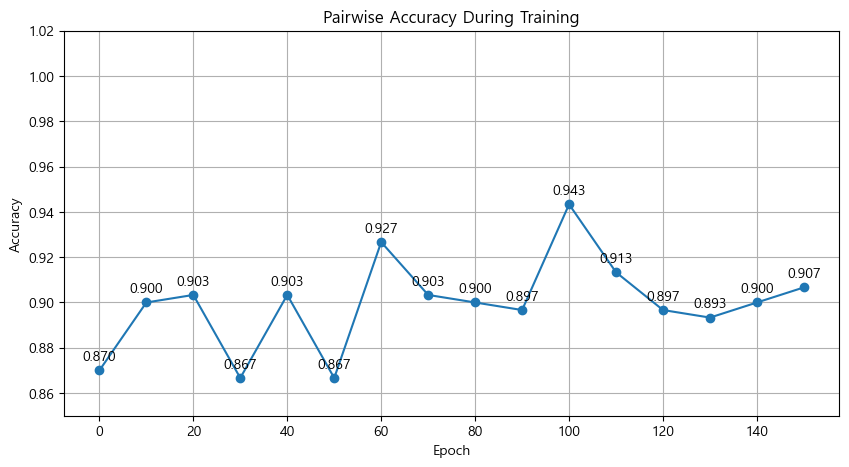

In [73]:
import matplotlib.pyplot as plt

epochs = list(range(0, len(accuracy_list)*10, 10))

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy_list, marker='o')
plt.title("Pairwise Accuracy During Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1.02)

for i in range(len(epochs)):
    plt.text(epochs[i], accuracy_list[i] + 0.003, f"{accuracy_list[i]:.3f}", ha='center', va='bottom', fontsize=10)

plt.grid(True)
plt.show()
